In [1]:
import sys
import os
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import PlanesDistCalc as pdc
import LoadStruct as lst
import LigandToResidue as ltr
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns
from matplotlib.colors import ListedColormap
from collections import defaultdict
plt.style.use('default')
import math
plt.rcParams["font.family"] = "Gulasch", "Times", "Times New Roman", "serif"
res_i_name = 'PHE'
res_j_name = 'TYR'
residue_i_name = 'PHE'
residue_j_name = 'TYR'

In [3]:
def reduce_vector_angles(vec_angles):
    reduced_angles = []
    
    for angle in vec_angles:
        angle = angle % 360  # make sure angle is in the range [0, 360)
        
        if angle > 180:
            angle = 360 - angle
        
        reduced_angles.append(angle)
    
    return reduced_angles

def xyz_to_pdb(input_filename: str, dir_path: str):
    '''take a xyz file of pairwise converged interaction of truncated amino acids side-chain,
    and transform to a pdb identified ligand in a pdb format using biopython formatting rules.
    The new file gets a 'trj' prefix'''
    if not dir_path.endswith('/'):
        dir_path = dir_path + '/'
    #step A: renumber the identical atoms to distinguish them for later renaming
    ligands_num = 2 #ltr.get_ligands_num(input_filename, dir_path)
    #create the sorted mid step file
    final_input_filename = 'sorted_' + input_filename 
    ltr.create_output(ligands_num, input_filename, dir_path)
    #step B: use the sorted file as a pdb file, and a dictionary of well defined bond lengths to identify the residue
    out_path = dir_path + 'pdbs/'
    out_file = ltr.create_greek_pdb_output(ligands_num, final_input_filename, dir_path, out_path)
    return out_file

def assign_post_opt_params(res_i_name: str,res_j_name: str,final_path: str, file: str, list_confs: list) -> list:
    '''Extract P,D,T1,T2 values from a given pdb file and append to the provided list'''
    pdb_file = final_path + file
    struct = lst.get_pdb_structure(pdb_file)
    chains_dict = lst.create_chain_dict(struct)

    pdbs_path='<path_where_all_references_files_are_stored>'

    reference_res_i, reference_coord_i = pdc.assign_reference_res(res_i_name, pdbs_path)
    reference_res_j, reference_coord_j = pdc.assign_reference_res(res_j_name, pdbs_path)
    shortest_thresh = 10
    centroid_dist_thresh = 10

    #pairwise post-analysis
    list_pairs = []
    res_arr = []
    for chain_id, chain_obj in chains_dict.items():
        for residue in chain_obj.get_list():
            res_arr.append(residue)
    residue_i = res_arr[0]
    residue_j = res_arr[1]

    if pdc.is_H_bond(residue_i, residue_j):
        print(file)
        is_H_b = True
    else:
        is_H_b = False

    if pdc.is_CH_bond(residue_i, residue_j):
        is_CH_b = True
    else:
        is_CH_b = False

    if pdc.is_pi_stacked(residue_i, residue_j):
        is_stacked = True
    else:
        is_stacked = False

    residue_i_idx = residue_i.get_id()[1]
    residue_j_idx = residue_j.get_id()[1]
    chain_id = 'A'
    title='RES'
    list_pairs = pdc.assign_X_Y_phi_geometry_params(residue_i, residue_i_idx, residue_j, residue_j_idx,shortest_thresh, centroid_dist_thresh, title, chain_id,list_pairs,reference_res_i, reference_res_j, res_i_name)
    P_val = list_pairs[0]['P']
    D_val = list_pairs[0]['Centroids_dist']
    T1_val = list_pairs[0]['Ttheta1']
    T2_val = list_pairs[0]['Ttheta2']
    Phi1_val = list_pairs[0]['Tphi1']
    Phi2_val = list_pairs[0]['Tphi2']

    split_filename = file.split('_')
    pdb_name = split_filename[1]
    chain_id = split_filename[2]
    res_i_id = split_filename[3]
    if split_filename[4] == residue_i_name:
        res_j_id = split_filename[5]
    else:
        res_j_id = split_filename[4]

    list_confs.append({"pdb_file": pdb_name,
                                    "chain_id": chain_id,
                                    "res_i_id": res_i_id,
                                    "res_j_id": res_j_id,
                                    "P": P_val,
                                    "D": D_val,
                                    "Ttheta1": T1_val,
                                    "Ttheta2": T2_val,
                                    "Phi1": Phi1_val,
                                    "Phi2": Phi2_val,
                                    "H-bond": is_H_b,
                                    "CH_bond": is_CH_b,
                                    "is_stacked": is_stacked
                                    })

    return list_confs


In [ ]:

dir_path = f'<path_where_all_pairwise_pdbs_are_stored_with_{res_i_name}_{res_j_name}>'
list_confs = []

final_path = f'<path_where_to_store_all_final_pdb_files>'
#analyzed file
for filename in os.listdir(dir_path):
    # if filename == '2IWZ_A_348_380_HIS_LYS_idx_6286_conv.xyz.pdb':
    f = os.path.join(dir_path, filename)
    #check if it is indeed pdb and has not ran before (not a sorted mid-file)
    if (not filename.startswith('sort') ) and filename.endswith('.pdb'):
        #print(filename)
        print(filename)
        if not f'sorted_{filename}' in os.listdir(dir_path):
            out_file = xyz_to_pdb(filename, dir_path)
        else:
            out_file = 'trj_' + filename
        
        assign_post_opt_params(res_i_name,res_j_name,final_path, out_file, list_confs)

confs_arr = pd.DataFrame(list_confs)
confs_arr.to_csv(f'csv_files/{res_i_name}_{res_j_name}_xyz_confs_phi.csv')

In [4]:
def extract_sptial_params(file_name,suffix):
    ''' extract digits from a string according to position'''
    splitted_name = file_name.split('_')
    pdb_file = splitted_name[0]
    chain_id = splitted_name[1]
    res_i_id = splitted_name[2]
    
    if splitted_name[3] == 'PHE':
        res_i_name = splitted_name[3]
        res_j_id = splitted_name[4]
    else:        
        res_j_id = splitted_name[3]
        res_i_name = splitted_name[4]
    # print(pdb_file, chain_id, res_i_id, res_j_id, res_i_name)
    return pdb_file,chain_id,res_i_id,res_i_name,res_j_id


def extract_struct_id(all_confs_df,pdb_file,chain_id,res_i_id,res_j_id):
    '''find conformation satisfying pdb name, chain id, and the two residues and return its location in all confs df'''
    for i in range(all_confs_df['pdb_file'].size):
        #print(all_confs_df['pdb_file'][i], all_confs_df['chain_id'][i], all_confs_df['res_i_id'][i], all_confs_df['res_j_id'][i])
        if all_confs_df['pdb_file'][i] == pdb_file and all_confs_df['chain_id'][i] == chain_id and all_confs_df['res_i_id'][i] == int(res_i_id) and all_confs_df['res_j_id'][i] == int(res_j_id):
            return i
    raise ValueError("missing file")


all_confs_path = f"csv_files/{residue_i_name}_{residue_j_name}_xyz_confs_phi.csv"
all_confs_df = pd.read_csv(all_confs_path, index_col=0)
P_vals = []
D_vals = []
T1_vals = []
T2_vals = []
Phi1_vals = []
Phi2_vals = []
binding_ener_vals = []
pdb_arr = []
chain_arr = []
res_i_arr = []
res_j_arr = []
is_H_b_arr = []
is_CH_arr = []
is_stacked_arr = []
names_file = f"txt_files/{residue_i_name}_{residue_j_name}_ener_non_red.txt"
factor = 627.5 # kcal/mol*Hartree

with open(names_file, 'r') as f:
    first_time = True

    for line in f:
        if not '_' in line:
            break
        splited_line = line.split(' ')
        name = splited_line[0]
        energy = splited_line[1]

        if name.startswith('ref') and not first_time:
            ref2_ener = energy
            continue
        if name.startswith('ref') and first_time:
            ref1_ener = energy
            first_time = False
            continue

        assert 'ref1_ener' in locals(), "Error: Variable ref1_ener does not exist, check the txt input file first line"
        assert 'ref2_ener' in locals(), "Error: Variable ref2_ener does not exist, check the txt input file second line"

        file_name = name
        pdb_file,chain_id,res_i_id,residue_i_name,res_j_id = extract_sptial_params(file_name, '.xyz.engrad')
        pdb_arr.append(pdb_file)
        chain_arr.append(chain_id)
        res_i_arr.append(res_i_id)
        res_j_arr.append(res_j_id)
        index = int(extract_struct_id(all_confs_df,pdb_file,chain_id,res_i_id,res_j_id))
        #print(index)
        P_vals.append(all_confs_df.iloc[index]['P'])
        D_vals.append(all_confs_df.iloc[index]['D'])
        T1_vals.append(all_confs_df.iloc[index]['Ttheta1'])
        T2_vals.append(all_confs_df.iloc[index]['Ttheta2'])
        Phi1_vals.append(all_confs_df.iloc[index]['Phi1'])
        Phi2_vals.append(all_confs_df.iloc[index]['Phi2'])
        is_H_b_arr.append(all_confs_df.iloc[index]['H-bond'])
        is_CH_arr.append(all_confs_df.iloc[index]['CH_bond'])
        is_stacked_arr.append(all_confs_df.iloc[index]['is_stacked'])
        current_ener = (float(energy) - float(ref1_ener) - float(ref2_ener))*factor
        binding_ener_vals.append(current_ener)

P_vals = np.array(P_vals)
D_vals = np.array(D_vals)
T1_vals = np.array(T1_vals)
T2_vals = np.array(T2_vals)
Phi1_vals = np.array(Phi1_vals)
Phi2_vals = np.array(Phi2_vals)

binding_ener_vals = np.array(binding_ener_vals)
pdb_arr = np.array(pdb_arr)
chain_arr = np.array(chain_arr)
res_i_arr = np.array(res_i_arr)
res_j_arr = np.array(res_j_arr)
is_H_b_arr = np.array(is_H_b_arr) 
is_CH_arr = np.array(is_CH_arr)
is_stacked_arr = np.array(is_stacked_arr)
clustered_data = pd.read_csv(f'csv_files/{residue_i_name}_{residue_j_name}_params_phi_Hb_minus_ref.csv')
clustered_D = clustered_data['Centroids_dist']
clustered_P = clustered_data['P']
clustered_T1 = clustered_data['Ttheta1']
clustered_T2 = clustered_data['Ttheta2']
clustered_Phi1 = clustered_data['Tphi1']
clustered_Phi2 = clustered_data['Tphi2']
clustered_H_b = clustered_data['H-bond']

ND_data = pd.read_csv(f'csv_files/{residue_i_name}_{residue_j_name}_params_phi_Hb_ND_minus_non_redundant.csv')
ND_D = ND_data['Centroids_dist']
ND_P = ND_data['P']
ND_T1 = ND_data['Ttheta1']
ND_T2 = ND_data['Ttheta2']
ND_Phi1 = ND_data['Tphi1']
ND_Phi2 = ND_data['Tphi2']
ND_H_b = ND_data['H-bond']

datasets = [clustered_D, ND_D]
all_D = pd.concat(datasets)
datasets = [clustered_P, ND_P]
all_P = pd.concat(datasets)
datasets = [clustered_T1, ND_T1]
all_T1 = pd.concat(datasets)
datasets = [clustered_T2, ND_T2]
all_T2 = pd.concat(datasets)
datasets = [clustered_Phi1, ND_Phi1]
all_Phi1 = pd.concat(datasets)
datasets = [clustered_Phi2, ND_Phi2]
all_Phi2 = pd.concat(datasets)
datasets = [clustered_H_b, ND_H_b]
all_H_b = pd.concat(datasets)

'~~~~ ONLY H-B ~~~~~~~~~~~~~~~~~`'
all_D_Hb = all_D[all_H_b==True]
all_P_Hb = all_P[all_H_b==True]
all_T1_Hb = all_T1[all_H_b==True]
all_T2_Hb = all_T2[all_H_b==True]
all_Phi11_Hb = all_Phi1[all_H_b==True]
all_Phi12_Hb = all_Phi2[all_H_b==True]

'~~~~ EXCLUDING H-B ~~~~~~~~~~~~~~~~~`'
all_D_no_Hb = all_D[all_H_b==False]
all_P_no_Hb = all_P[all_H_b==False]
all_T1_no_Hb = all_T1[all_H_b==False]
all_T2_no_Hb = all_T2[all_H_b==False]
all_Phi11_no_Hb = all_Phi1[all_H_b==False]
all_Phi12_no_Hb = all_Phi2[all_H_b==False]

Phi1_vals = reduce_vector_angles(Phi1_vals)
Phi2_vals = reduce_vector_angles(Phi2_vals)

all_Phi1 = reduce_vector_angles(all_Phi1)
all_Phi2 = reduce_vector_angles(all_Phi2)
all_Phi11_Hb = reduce_vector_angles(all_Phi11_Hb)
all_Phi12_Hb = reduce_vector_angles(all_Phi12_Hb)
all_Phi11_no_Hb = reduce_vector_angles(all_Phi11_no_Hb)
all_Phi12_no_Hb = reduce_vector_angles(all_Phi12_no_Hb)


In [5]:
def plot_x_y_over_counts_Hb(fig, x_all,y_all,x,y,z,E,x_label,y_label,z_label,is_z_dist,ax,legend_loc, is_Phi_x, is_Phi_y, is_D_x, is_global):

    heatmap, xedges, yedges = np.histogram2d(x_all, y_all, bins=50)

    E_min = E[is_H_b_arr == False].min()
    E_max =  -0.5

    if is_global:
        E_min = -5
    # Plot the heatmap as a contour plot
    extent = [xedges[0], xedges[-1], yedges[0], yedges[-1]]
    #im1 = ax.contourf(heatmap.T, extent=extent, cmap='magma_r')
    im1 = ax.contourf(heatmap.T, extent=extent, cmap='pink_r')

    # Add a colorbar for the heatmap
    cbar = fig.colorbar(im1,ax=ax)
    cbar.set_label('Counts')

    #4D plot
    marker_sizes = []

    if is_z_dist:
        for p in z:
            marker_sizes.append(p**4/4)

    else:
        for p in z:
            marker_sizes.append(p*2)
    df = pd.DataFrame({'x':x,'y': y, 'E': E, 'marker': marker_sizes, 'is_Hb': is_H_b_arr, 'is_CH': is_CH_arr, 'is_stacked': is_stacked_arr}).sort_values('marker',ascending=False)
    for i in range(len(marker_sizes)):
        if df.at[i,'is_Hb'] == True:
            im = ax.scatter(df.at[i,'x'],df.at[i,'y'],c=df.at[i,'E'],
            cmap='jet_r', vmin=E_min, vmax=E_max,marker='>', s=df.at[i,'marker'], alpha=2.5/((4*df.at[i,'marker'])**0.25), edgecolors='k')        
        if df.at[i,'is_CH'] == True:
            im = ax.scatter(df.at[i,'x'],df.at[i,'y'],c=df.at[i,'E'],
            cmap='jet_r', vmin=E_min, vmax=E_max,marker='s', s=df.at[i,'marker'], alpha=2.5/((4*df.at[i,'marker'])**0.25), edgecolors='k')
        if df.at[i,'is_stacked'] == True:
            im = ax.scatter(df.at[i,'x'],df.at[i,'y'],c=df.at[i,'E'],
            cmap='jet_r', vmin=E_min, vmax=E_max,marker='P', s=df.at[i,'marker'], alpha=2.5/((4*df.at[i,'marker'])**0.25), edgecolors='k')            
        if not df.at[i,'is_Hb'] == True and not df.at[i,'is_CH'] == True and not df.at[i,'is_stacked'] == True:     
            im = ax.scatter(df.at[i,'x'],df.at[i,'y'],c=df.at[i,'E'],
        cmap='jet_r', marker='o', vmin=E_min, vmax=E_max, s=df.at[i,'marker'], alpha=2.5/((4*df.at[i,'marker'])**0.25), edgecolors='k')
        #im = ax.scatter(x[i],y[i],c=E[i], cmap='jet_r', marker='o', vmin=-5, vmax=max(E), s=marker_sizes[i], alpha=0.4, edgecolors='k')


    ax.set_xlabel(x_label)
    ax.set_ylabel(y_label)

    if is_Phi_x:
        ax.set_xticks(range(0, 181, 30))
        ax.set_xlim(0, 180)
    elif is_D_x:       
        ax.set_xlim(3.2, 6.0)
    else:
        ax.set_xticks(range(0, 91, 10))
        ax.set_xlim(0, 90)

    if is_Phi_y:
        ax.set_yticks(range(0, 181, 30))
        ax.set_ylim(0, 180)
    else: # is angle
        ax.set_yticks(range(0, 91, 10))
        ax.set_ylim(0, 90)     
    ax.set_title(f'{res_i_name}-{res_j_name} Binding Energies ', fontweight='bold')
    #plt.legend()

    cbar = fig.colorbar(im,ax=ax)
    cbar.set_label('Binding Energy [kcal/mol]')

        #ax.legend(bbox_to_anchor=(1.33, 0.02), loc='upper right', title=z_label)
    ax.scatter([], [], c='k', alpha=0.3, s=150, marker='>', label='H-bonds')
    ax.scatter([], [], c='k', alpha=0.3, s=150, marker='s', label='CH-pi')
    ax.scatter([], [], c='k', alpha=0.3, s=150, marker='P', label='stacked')
    ax.scatter([], [], c='k', alpha=0.3, s=100, marker='o', label='other')

    ax.legend(loc=legend_loc)

    #plt.show()

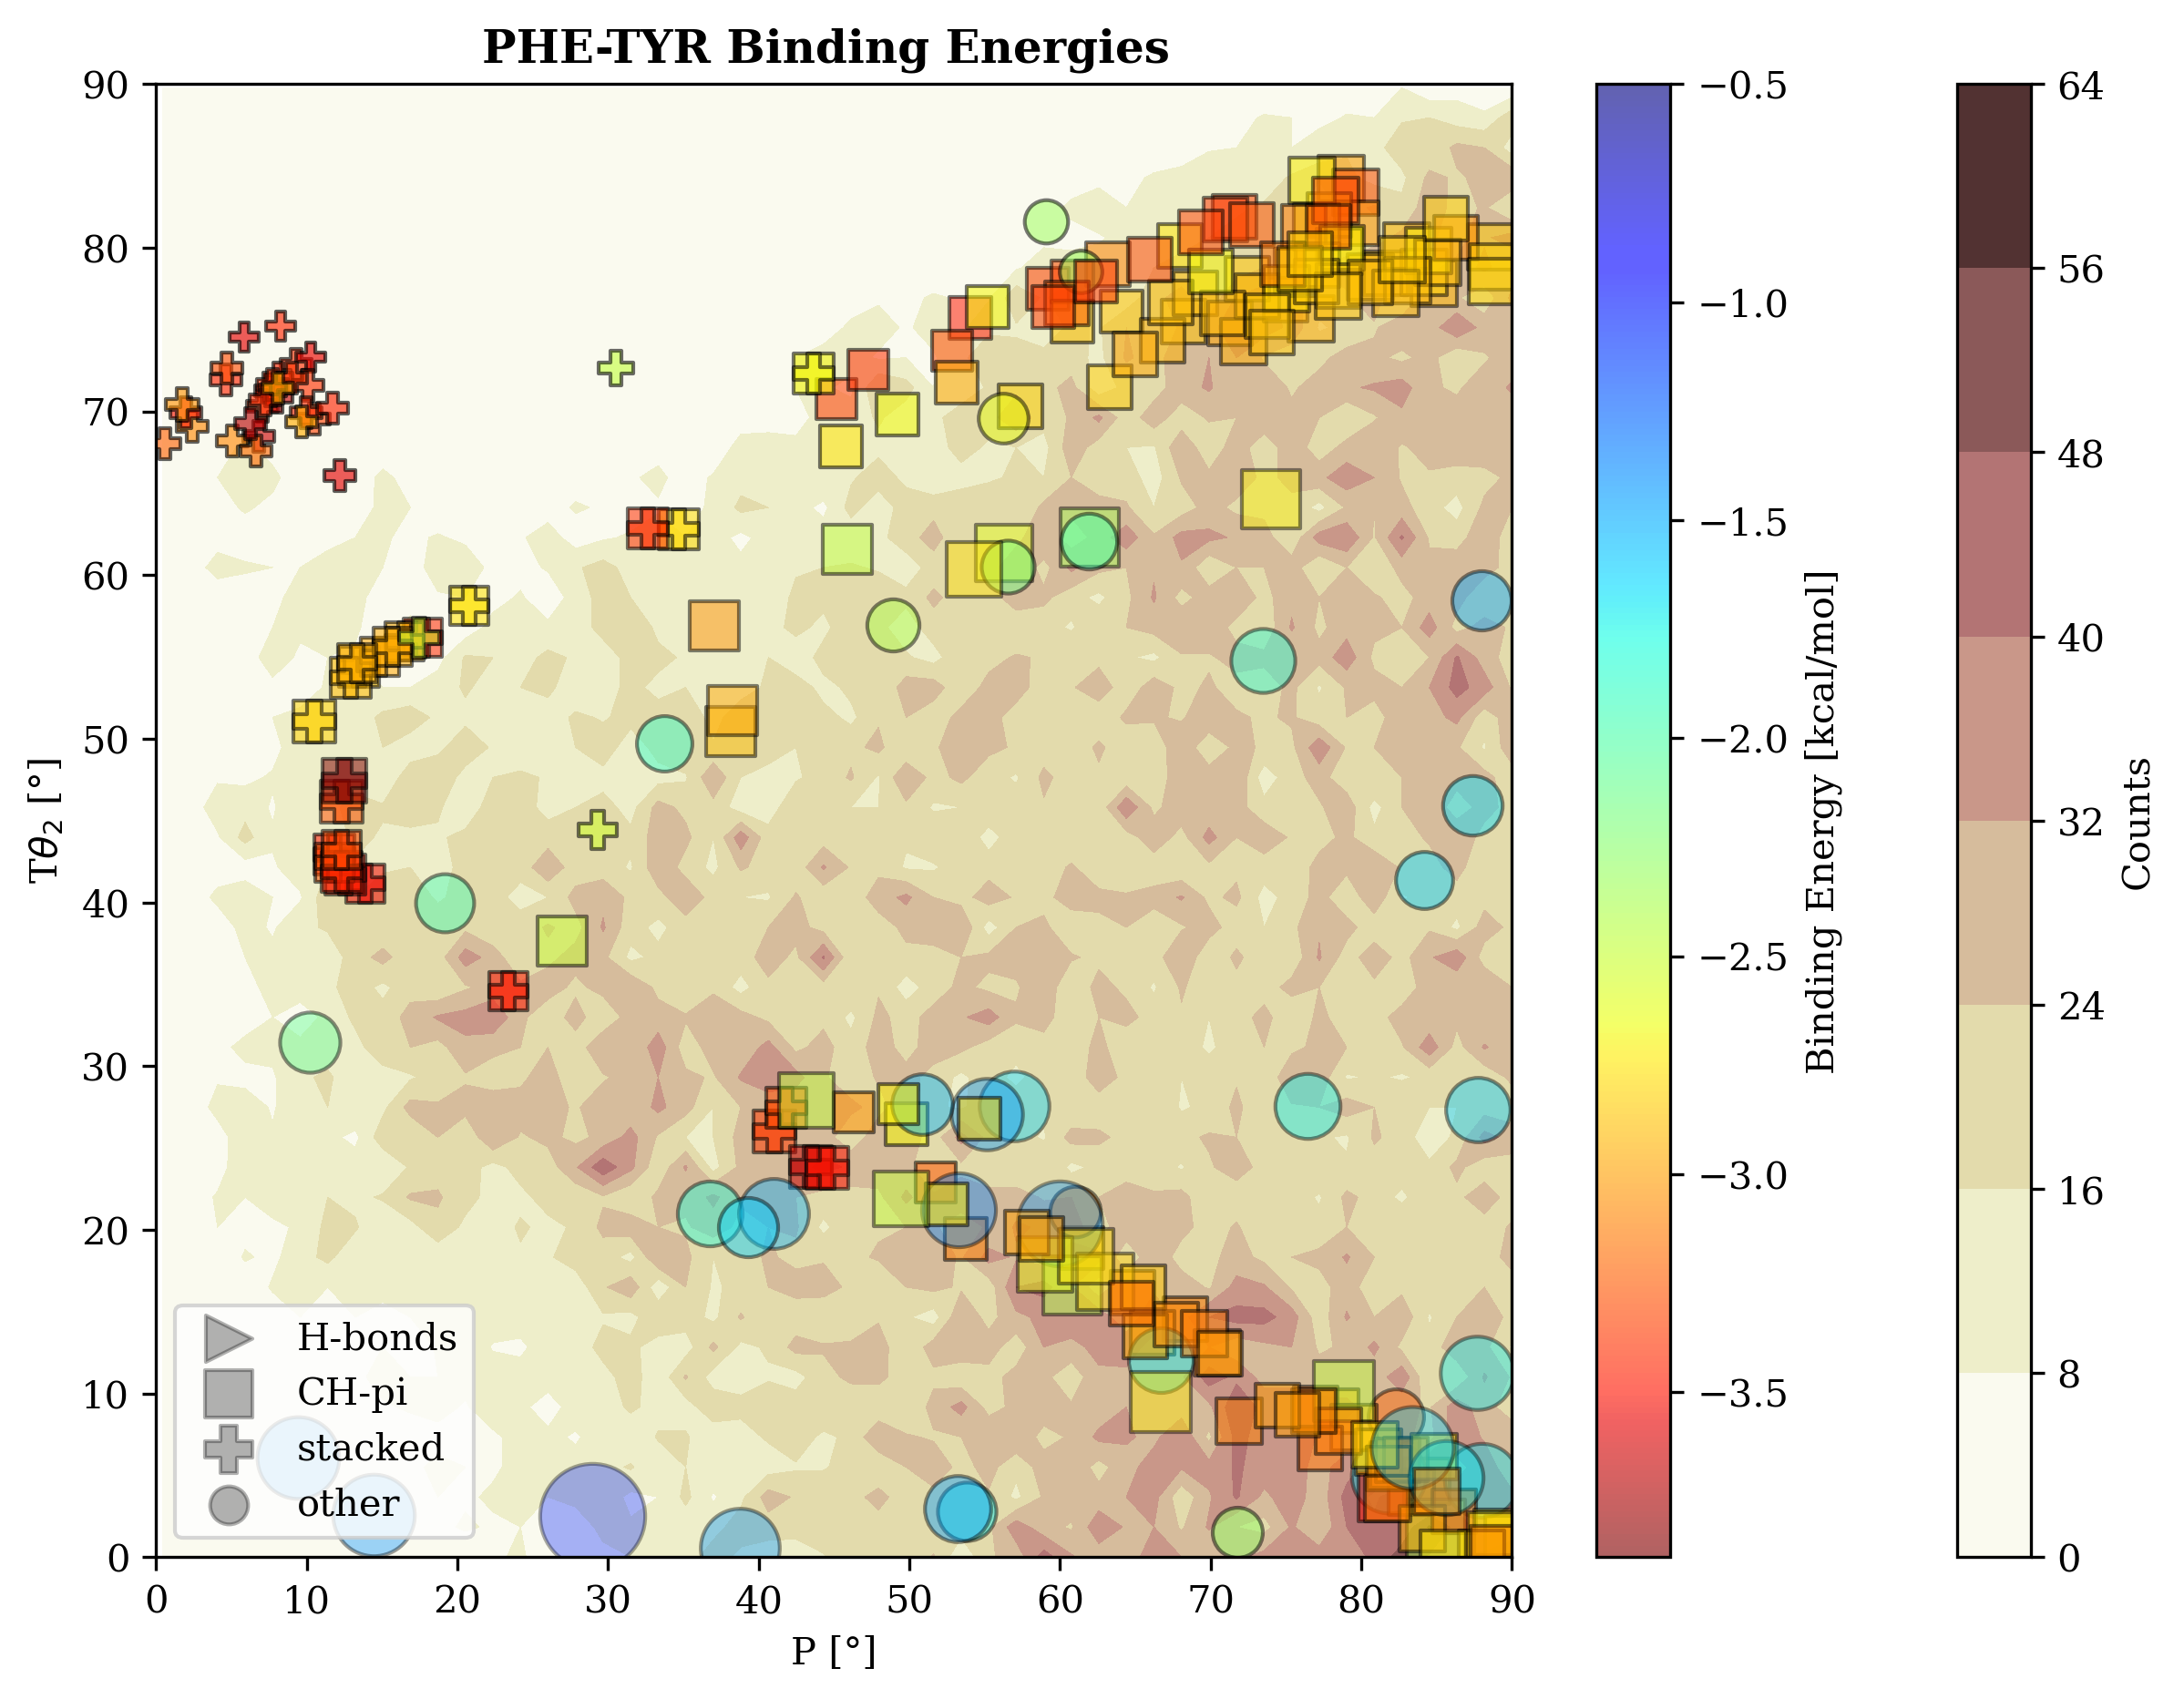

In [6]:
########################### PLOTING FINAL ??? 

fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(10, 7))
fig.set_dpi(300)
#ax1 = axes[0]
'''~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~` X-AXIS IS P ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~'''
is_D_x = False 
is_Phi_x = False
is_Phi_y = False

x_all = all_P
y_all = all_T2
x = P_vals
y = T2_vals
z = D_vals
E = binding_ener_vals

x_label = 'P [\N{DEGREE SIGN}]'
y_label = 'T$\\theta_2$ [\N{DEGREE SIGN}]'
z_label = 'Distance [\N{ANGSTROM SIGN}]'
is_z_dist = True
plot_x_y_over_counts_Hb(fig, x_all, y_all, x, y, z, E, x_label, y_label, z_label, is_z_dist, axes, legend_loc='lower left', is_Phi_x=is_Phi_x, is_Phi_y=is_Phi_y, is_D_x=is_D_x, is_global=False)

plt.show()